# Using the ml4qc package for a specific example analysis ("CATI1")

This workbook demonstrates an example analysis for a particular CATI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CATI1".

This is a basic proof-of-concept project designed to explore the potential for ML-based tools to identify outliers and submissions that are likely to be rejected by a human reviewer. The project collected some but not all possible metadata, and every submission was reviewed.

In this case, prediction precision ranges from 10% to 43% (against a base rate of 3.8%), depending on the model and random subsample. It suggests that human review, guided by ML model prediction, can be significantly more effective than purely random review.

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we use the [surveydata](https://surveydata.readthedocs.io/) package to load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **Surveyor_ID** - ID of enumerator who conducted the interview
* **duration** - Total number of seconds spent editing form
* **instance_time** - Timestamp in an unusual format; will be dropped
* **TA** - Relative path to text audit `.csv` file
* **pct_conversation** - Percent of form-editing time when conversation was detected ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID

In [2]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones
# (needed in this case because the storage and text audit formats used don't themselves include timezone info)
data_tz = pytz.timezone("Asia/Kabul").zone
collection_tz = pytz.timezone("Asia/Kabul").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab1/cati1/cati1.csv"), attachments_available=True)

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits in wide format
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text wide-format audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate      6032
starttime           6032
endtime             6031
Surveyor_ID         6032
duration            6032
instance_time       6032
TA                  6032
pct_conversation    6031
review_status       6032
review_quality      6032
dtype: int64

Submission DataFrame review status and quality:
APPROVED    5800
REJECTED     232
Name: review_status, dtype: Int64
OKAY    2992
GOOD    2761
POOR     279
Name: review_quality, dtype: Int64

Text audit DataFrame field counts:
field         1244960
duration_s    1244960
visited_s     1244960
dtype: int64

Combined DataFrame field counts:
SubmissionDate                                                                              6032
starttime                                                                                   6032
endtime                                                                                     6031
Surveyor_ID                                                            

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict, and we preprocess the data to prepare for binary classification prediction using one of three target definitions:

1. Rejected submissions
2. Submissions classified as poor quality
3. Submissions that are not APPROVED as GOOD quality (i.e., rejected or another quality)

Here, we use PCA to reduce our feature dimensions, targeting 95% variance retention. This allows ML model training and validation to be much faster.

Since this is a static *ex post* dataset with all submissions already reviewed, we use 75% of the data for training and 25% for testing (our prediction set).

In [3]:
%%time

from ml4qc import SurveyMLClassifier

# random state for reproducible results (or None)
random_state = 501

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.95

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["instance_time", "SubmissionDate", "starttime", "endtime", "duration", "TA"], axis=1).copy(deep=True)
starting_n = len(analysis_df.index)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]
ending_n = len(analysis_df.index)
print(f"Dropped {starting_n-ending_n}/{starting_n} observations with missing data, for a loss of {((starting_n-ending_n)/starting_n)*100:.2f}%")
print()

# organize DataFrames with features and classes for prediction
class_columns = ["review_status", "review_quality", "Surveyor_ID"]
classes_df = analysis_df.loc[:, class_columns]
features_df = analysis_df.drop(class_columns, axis=1)

# set our target for prediction
target_description = "REJECTED"
classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "REJECTED" else 0), axis=1)
# target_description = "POOR"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_quality"] == "POOR" else 0), axis=1)
# target_description = "Not APPROVED+GOOD"
# classes_df["target"] = classes_df.apply(lambda row: (0 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 1), axis=1)
target_df = pd.DataFrame(classes_df["target"])
print(f"Target description: {target_description}")
print(target_df.target.value_counts())
print()
print(f"Target base rate: {(len(target_df[target_df.target == 1])/len(target_df))*100:.2f}%")
print()

# create SurveyML object with 25% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.25, cv_when_training=True, random_state=random_state, verbose=True, n_jobs=-3, calibration_method='isotonic', threshold="optimal_f", threshold_value=1)

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

Dropped 2/6032 observations with missing data, for a loss of 0.03%

Target description: REJECTED
0    5798
1     232
Name: target, dtype: int64

Target base rate: 3.85%

numeric features: 6277
numeric_binary features: 2163
numeric_unit_interval features: 3690
numeric_other features: 424
datetime features: 0
other features: 2
  Starting training set shape: (4522, 6279)
Starting prediction set shape: (1508, 6279)
     Final training set shape: (4522, 674)
   Final prediction set shape: (1508, 674)
CPU times: user 3min 24s, sys: 7.55 s, total: 3min 31s
Wall time: 47.6 s


## Performing analysis

In the cells that follow, we perform a series of analyses using the `scikit-learn` and `Tensorflow Keras` libraries, making use of the utilities available in the `SurveyMLClassifier` class. These models have not been extensively tuned, and they currently require re-tuning whenever the target or dimensionality-reduction settings change above.

### Identifying outliers

First, however, we use the `identify_outliers()` method available in the base `SurveyML` class, to identify outliers and save them to disk.

In [4]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

# identify outliers
x_outlier_df = surveyml.identify_outliers()

# save results to .csv
x_outlier_df.to_csv(os.path.expanduser("~/ml4qc-data/collab1/cati1/outlier_predictions.csv"))

# combine outlier prediction with target classification and show crosstab
x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 129 (2.139303482587065%)
CPU times: user 6.12 s, sys: 2.31 s, total: 8.44 s
Wall time: 8.45 s


target,0,1
is_outlier,,
0,0.978786,0.974138
1,0.021214,0.025862


### Binary classification prediction with logistic regression

Here, we use logistic regression to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Logistic regression
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.03133330010673981
Parameters: {'C': 0.0008242861714196172, 'class_weight': None, 'penalty': 'l2'}

Running prediction model...

      Training set: (4522, 674) (169 positive)
    Prediction set: (1508, 674)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.199794578078004

Fitting model...

Cross-validating model on training set...

          Train accuracy:  97.43%
         Train precision:  72.27%
               Train F-1:  0.6
     Train ROC_AUC Score:  0.75
     Prediction accuracy:  95.89%
    Prediction precision:  51.28%
          Prediction F-1:  0.39
      Test ROC_AUC Score:  0.65


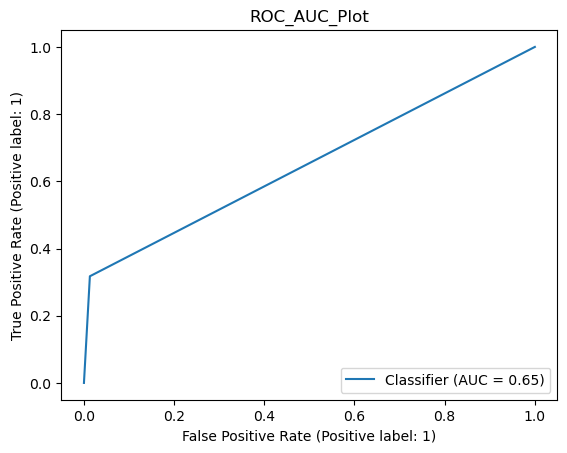

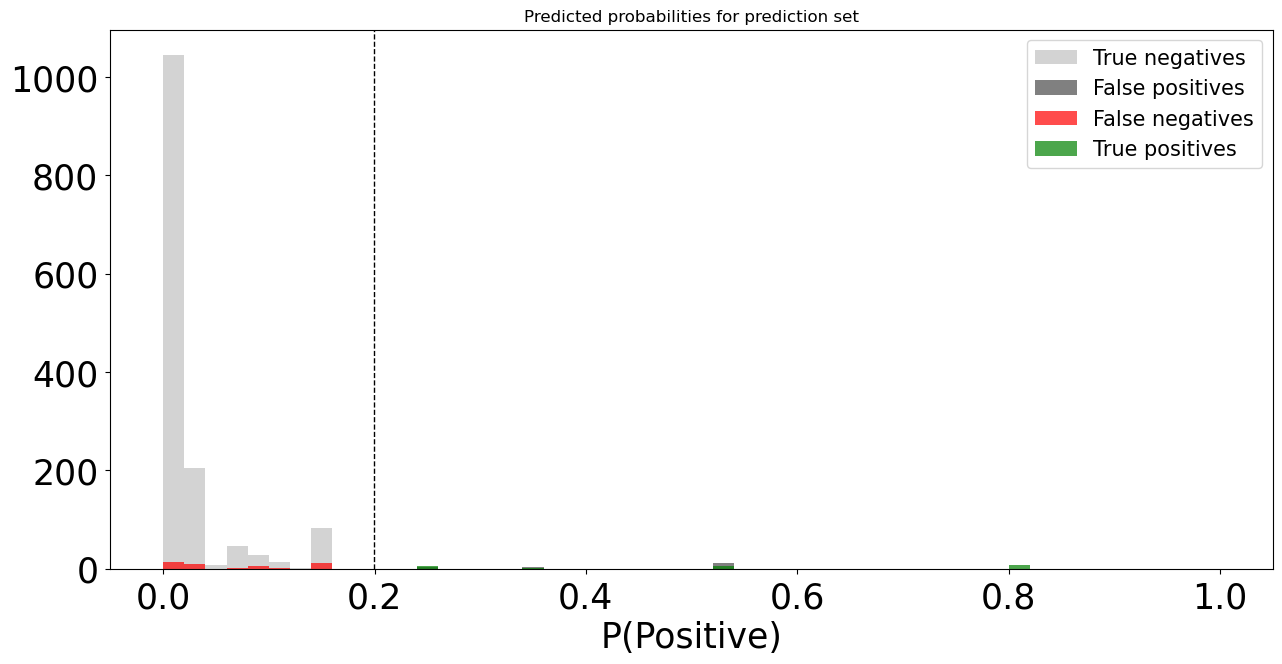

Test P(1) =  4.18%
Test P(1 | predicted 1) =  51.28%
Test P(1 | predicted 0) =  2.93%

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1445
           1       0.51      0.32      0.39        63

    accuracy                           0.96      1508
   macro avg       0.74      0.65      0.69      1508
weighted avg       0.95      0.96      0.95      1508



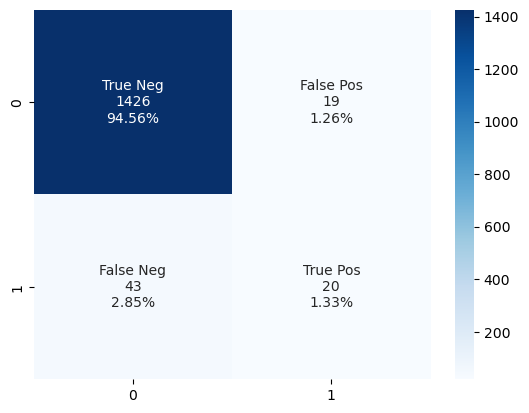

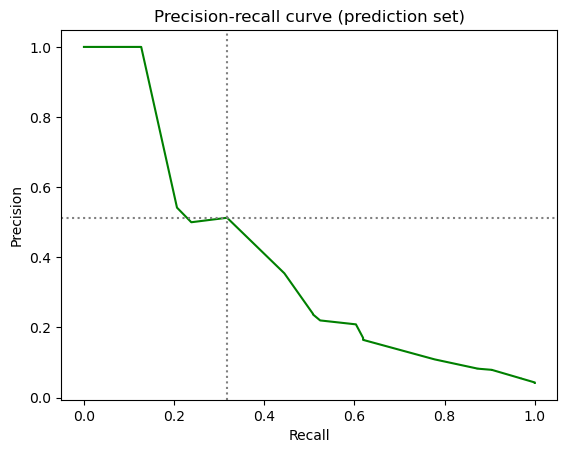

Cross validation results: 

fit_time: 0.527936601638794 (SD: 0.12950735322537774)
score_time: 0.007444063822428386 (SD: 0.005153457567445843)
test_accuracy: 0.9518647631154354 (SD: 0.006433716764516454)
test_precision: 0.34411976369594277 (SD: 0.08490028156377993)
test_f1: 0.30571770684604466 (SD: 0.06817106728751664)
test_roc_auc: 0.8022460300002607 (SD: 0.029035650548877173)
test_neg_log_loss: -0.150668582112337 (SD: 0.027487075722399494)
test_neg_brier_score: -0.031744879970047844 (SD: 0.0015745110890705639)

Predictions made: 1508
CPU times: user 5.41 s, sys: 805 ms, total: 6.22 s
Wall time: 2min 57s


In [50]:
%%time

model_description = "Logistic regression"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.linear_model import LogisticRegression

# Option 1: use cross validation to find the optimal hyperparameters
import sklearn as skl
classifier_lr = LogisticRegression(random_state=random_state, max_iter=2000)
search_params = {'C': skl.utils.fixes.loguniform(0.0001, 100), 'penalty': ['l2'], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_lr, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# # Option 2: use parameters from prior run
# params = {'C': 0.0008242861714196172, 'penalty': 'l2', 'class_weight': None}

# then fit the model using the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=random_state, max_iter=10000, **params)
predictions = surveyml.run_prediction_model(classifier_lr)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.coef_[0])

### Binary classification prediction with a decision tree

Here, we use a decision tree to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Decision tree
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.03597240458969361
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 2, 'class_weight': None}

Running prediction model...

      Training set: (4522, 674) (169 positive)
    Prediction set: (1508, 674)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.11863896283326318

Fitting model...

Cross-validating model on training set...



/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


          Train accuracy:  96.20%
         Train precision:  46.51%
               Train F-1:  0.19
     Train ROC_AUC Score:  0.56
     Prediction accuracy:  95.56%
    Prediction precision:  33.33%
          Prediction F-1:  0.11
      Test ROC_AUC Score:  0.53


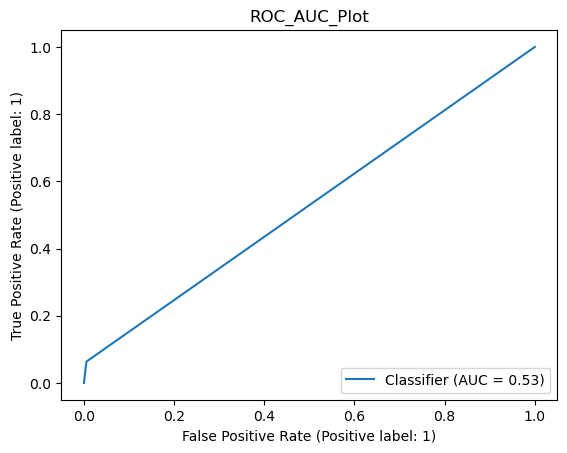

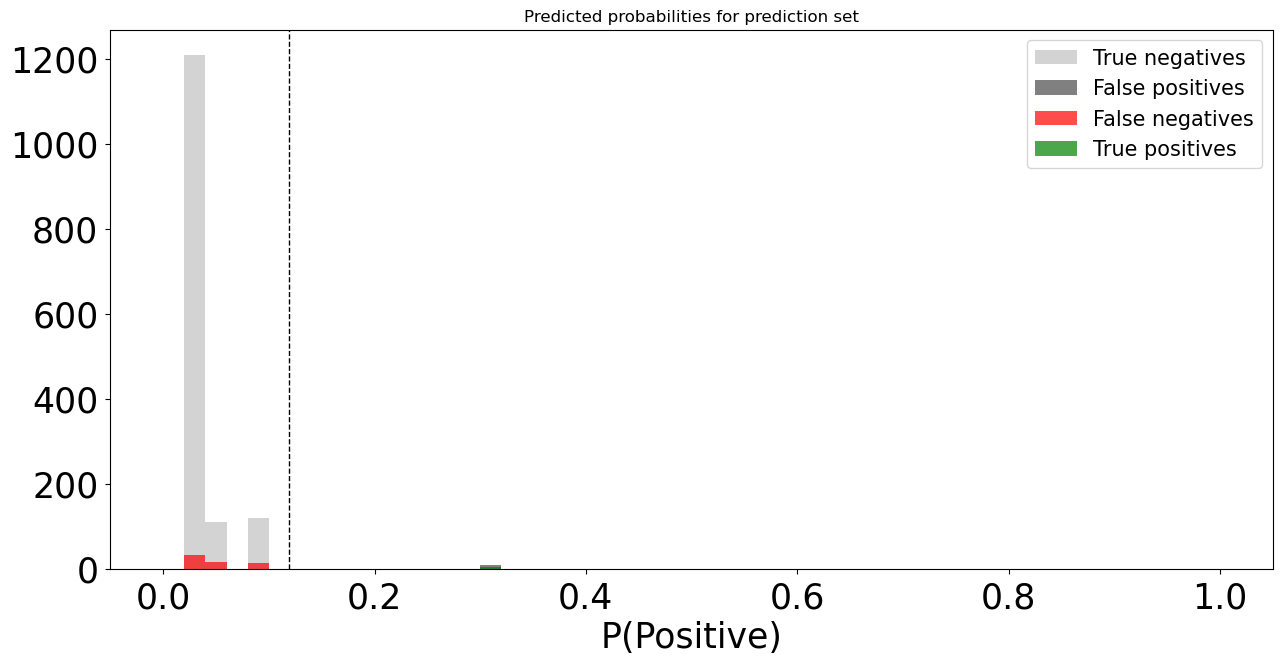

Test P(1) =  4.18%
Test P(1 | predicted 1) =  33.33%
Test P(1 | predicted 0) =  3.94%

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1445
           1       0.33      0.06      0.11        63

    accuracy                           0.96      1508
   macro avg       0.65      0.53      0.54      1508
weighted avg       0.93      0.96      0.94      1508



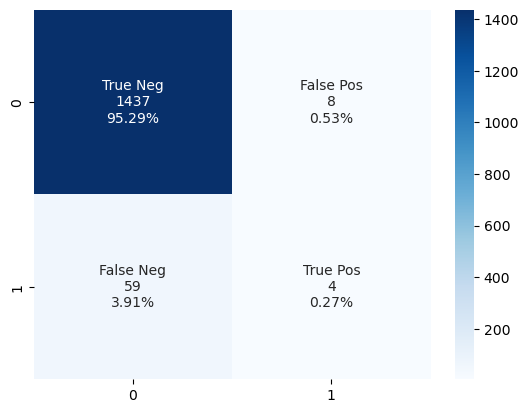

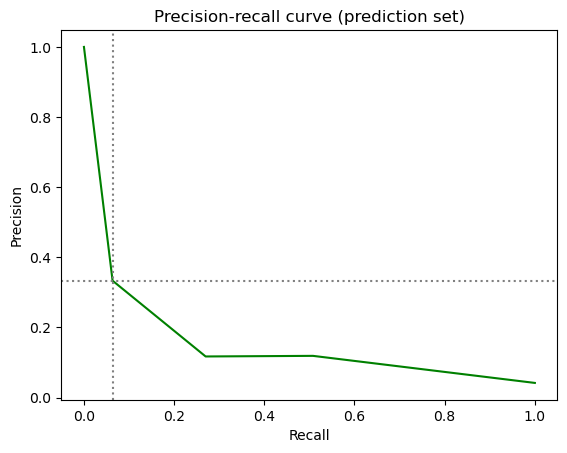

Cross validation results: 

fit_time: 0.8733203570048015 (SD: 0.0864358456518951)
score_time: 0.005702829360961914 (SD: 0.003345136980921971)
test_accuracy: 0.9436886194364313 (SD: 0.029290698833864676)
test_precision: 0.1454775326826285 (SD: 0.11883635785574814)
test_f1: 0.08623531604543552 (SD: 0.061784644889998803)
test_roc_auc: 0.642457989418572 (SD: 0.03603298824559942)
test_neg_log_loss: -0.16710149199458563 (SD: 0.06031006471088375)
test_neg_brier_score: -0.03560067610641401 (SD: 0.0016572828201736845)

Predictions made: 1508
CPU times: user 5.26 s, sys: 523 ms, total: 5.79 s
Wall time: 2min 22s


In [52]:
%%time

model_description = "Decision tree"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.tree import DecisionTreeClassifier

# first use cross validation to find the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_dt, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state, **params)
predictions = surveyml.run_prediction_model(classifier_dt)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with random forest

Here, we use random forest to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Random forest
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.034497670268158885
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 4, 'class_weight': None, 'bootstrap': True}

Running prediction model...

      Training set: (4522, 674) (169 positive)
    Prediction set: (1508, 674)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.08877924670866336

Fitting model...

Cross-validating model on training set...



/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


          Train accuracy:  94.45%
         Train precision:  36.69%
               Train F-1:  0.47
     Train ROC_AUC Score:  0.81
     Prediction accuracy:  90.78%
    Prediction precision:  18.85%
          Prediction F-1:  0.25
      Test ROC_AUC Score:  0.65


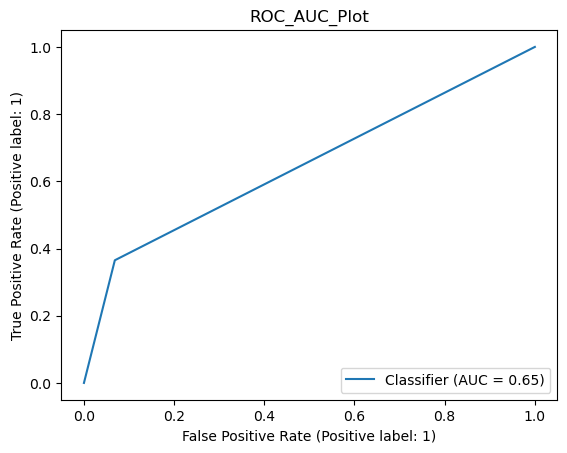

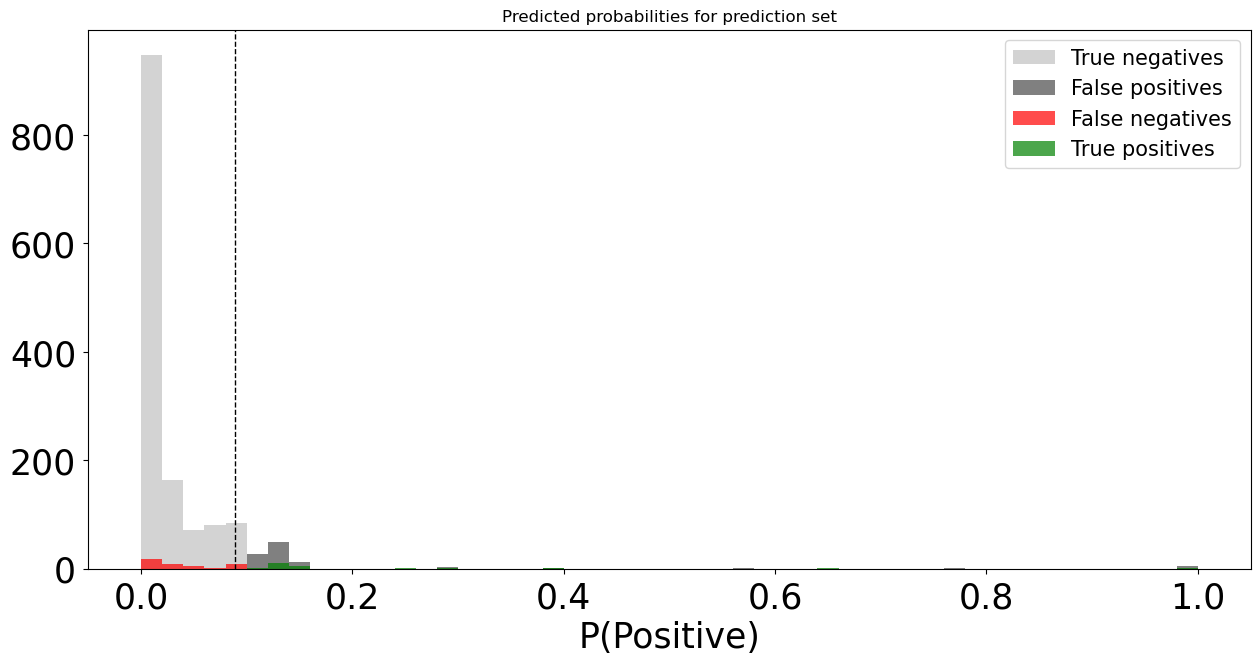

Test P(1) =  4.18%
Test P(1 | predicted 1) =  18.85%
Test P(1 | predicted 0) =  2.89%

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1445
           1       0.19      0.37      0.25        63

    accuracy                           0.91      1508
   macro avg       0.58      0.65      0.60      1508
weighted avg       0.94      0.91      0.92      1508



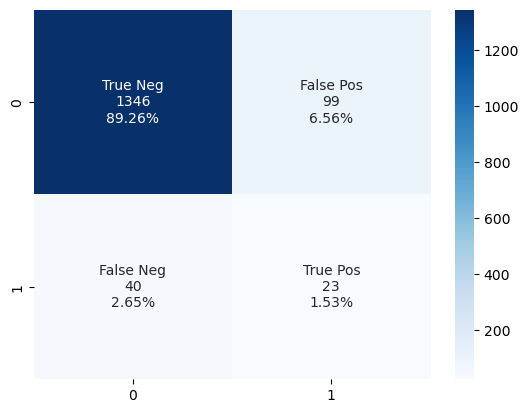

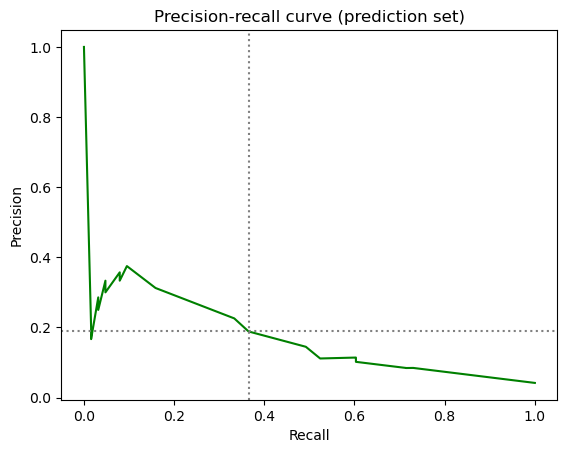

Cross validation results: 

fit_time: 936.7505440235138 (SD: 143.32042216104398)
score_time: 0.12606528600056965 (SD: 0.0839089026454708)
test_accuracy: 0.8629775583044054 (SD: 0.03726250706445999)
test_precision: 0.1317189069087614 (SD: 0.034533122798497094)
test_f1: 0.19860202412743788 (SD: 0.042540031809062795)
test_roc_auc: 0.753419536172102 (SD: 0.04112685752304531)
test_neg_log_loss: -0.14561451562180866 (SD: 0.011257451773423773)
test_neg_brier_score: -0.03448490924359162 (SD: 0.0007234203332854347)

Predictions made: 1508
CPU times: user 28min 13s, sys: 13.8 s, total: 28min 27s
Wall time: 2h 24min 20s


In [55]:
%%time

model_description = "Random forest"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.ensemble import RandomForestClassifier

# first use cross validation to find the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=50)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None], 'bootstrap': [True]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_rf, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_rf)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with XGBoost

Here, we use the XGBoost algorithm to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: XGBoost
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 54 candidates, totalling 810 fits


/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best neg_brier_score: -0.034019340487480135
Parameters: {'subsample': 1, 'scale_pos_weight': 1, 'min_child_weight': 1, 'max_depth': 2}

Running prediction model...

      Training set: (4522, 674) (169 positive)
    Prediction set: (1508, 674)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.11214996203780174

Fitting model...

Cross-validating model on training set...

          Train accuracy:  100.00%
         Train precision:  100.00%
               Train F-1:  1.0
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  92.97%
    Prediction precision:  24.71%
          Prediction F-1:  0.28
      Test ROC_AUC Score:  0.64


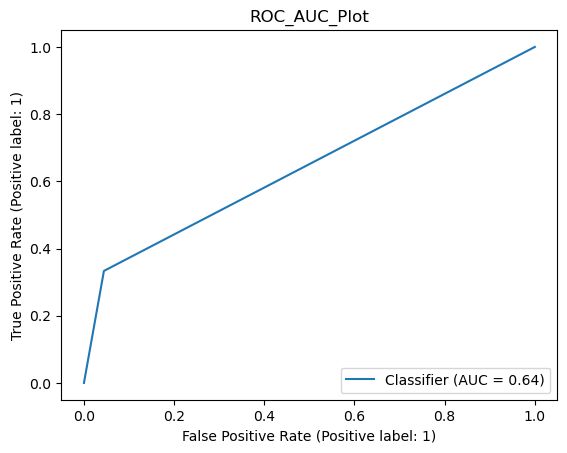

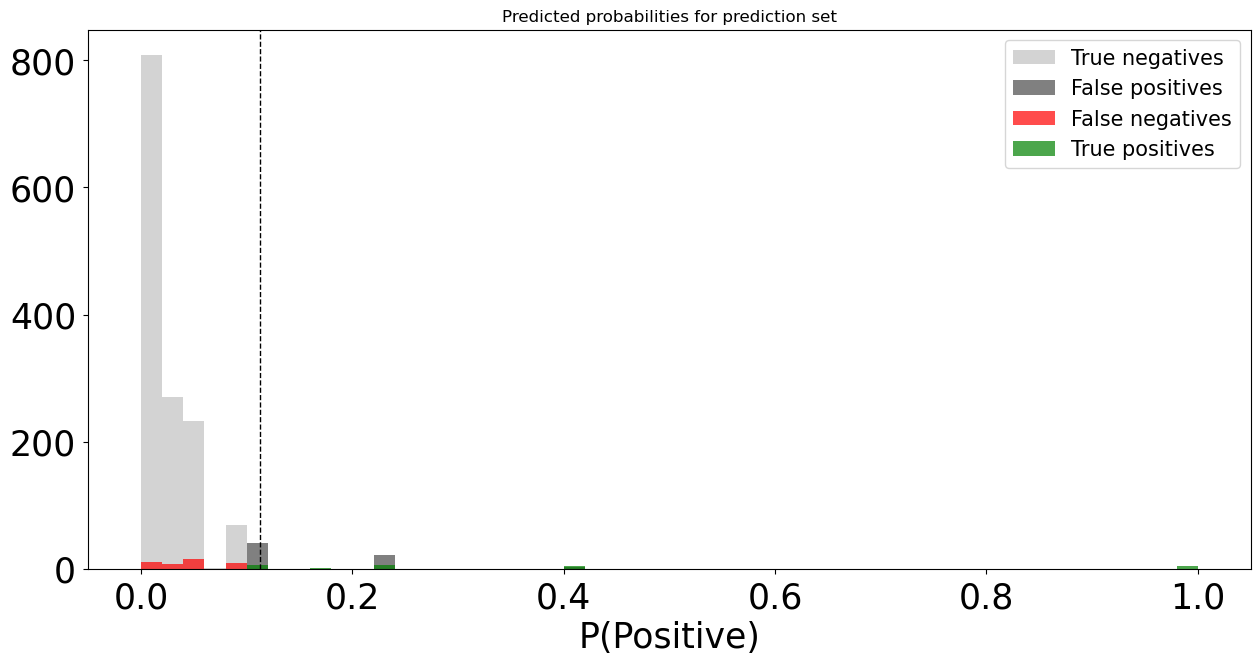

Test P(1) =  4.18%
Test P(1 | predicted 1) =  24.71%
Test P(1 | predicted 0) =  2.95%

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1445
           1       0.25      0.33      0.28        63

    accuracy                           0.93      1508
   macro avg       0.61      0.64      0.62      1508
weighted avg       0.94      0.93      0.93      1508



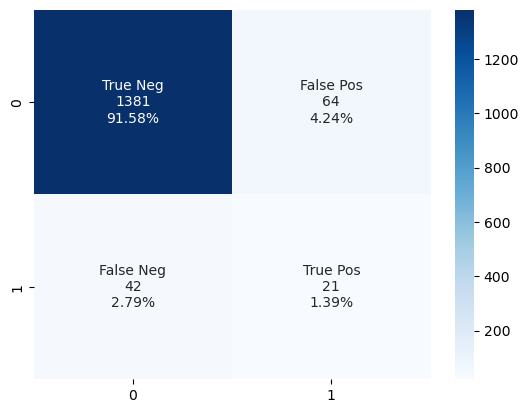

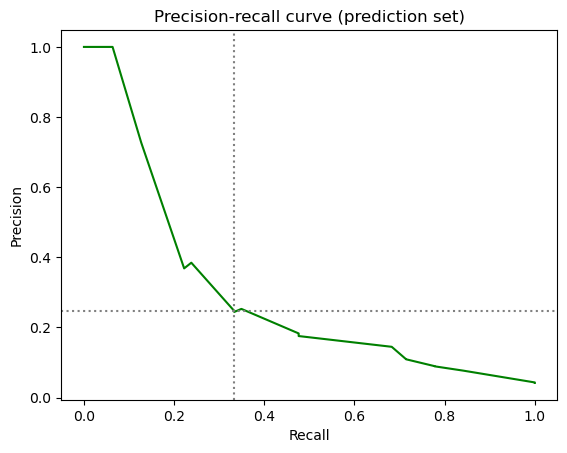

Cross validation results: 

fit_time: 113.71593820254007 (SD: 4.227831546340147)
score_time: 0.0411462942759196 (SD: 0.0387708318745709)
test_accuracy: 0.9385222216789713 (SD: 0.014920237955357917)
test_precision: 0.2264328817054279 (SD: 0.09305283582193756)
test_f1: 0.20280118226475055 (SD: 0.05764758861154556)
test_roc_auc: 0.718617441429194 (SD: 0.038884010984155275)
test_neg_log_loss: -0.15063965472979163 (SD: 0.013744861292968513)
test_neg_brier_score: -0.03411061708016138 (SD: 0.0011196891184553214)

Predictions made: 1508
CPU times: user 3min 16s, sys: 5.45 s, total: 3min 21s
Wall time: 16min 54s


In [53]:
%%time

model_description = "XGBoost"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from xgboost import XGBClassifier

# first use cross validation to find the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=50)
search_params = {'max_depth': [2, 3, 4, 5, 7, 10], 'min_child_weight': [1, 2, 4], 'subsample': [0.5, 0.75, 1], 'scale_pos_weight': [1]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_xb, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_xb)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with a neural network

Here, we use a neural network to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Neural network
     Scoring: neg_brier_score

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 674)               454950    
                                                                 
 dense_58 (Dense)            (None, 337)               227475    
                                                                 
 dense_59 (Dense)            (None, 1)                 338       
                                                                 
Total params: 682,763
Trainable params: 682,763
Non-trainable params: 0
_________________________________________________________________
None

Running prediction model...

      Training set: (4522, 674) (169 positive)
    Prediction set: (1508, 674)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...



2023-01-05 16:25:50.773209: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:25:50.774464: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:25:50.774744: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:25:50.774934: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:25:50.774955: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:26:14.183252: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:26:31.740260: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:26:31.741074: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   Final threshold: 0.24706879183650016

Fitting model...

Cross-validating model on training set...



2023-01-05 16:29:47.151938: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:29:57.639862: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2023-01-05 16:30:07.452255: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:30:40.340109: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:30:40.694783: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:30:41.668809: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-0

          Train accuracy:  97.57%
         Train precision:  83.91%
               Train F-1:  0.57
     Train ROC_AUC Score:  0.71
     Prediction accuracy:  96.02%
    Prediction precision:  55.17%
          Prediction F-1:  0.35
      Test ROC_AUC Score:  0.62


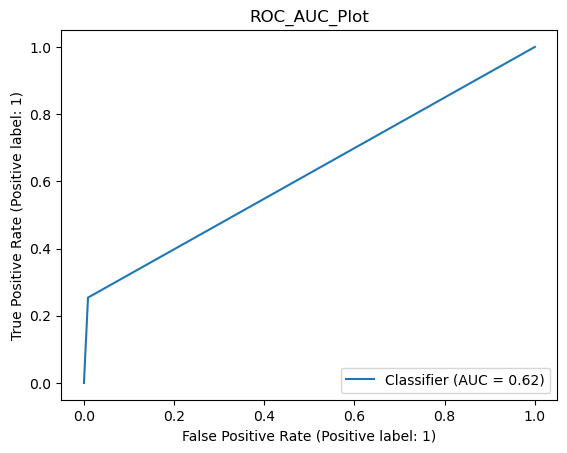

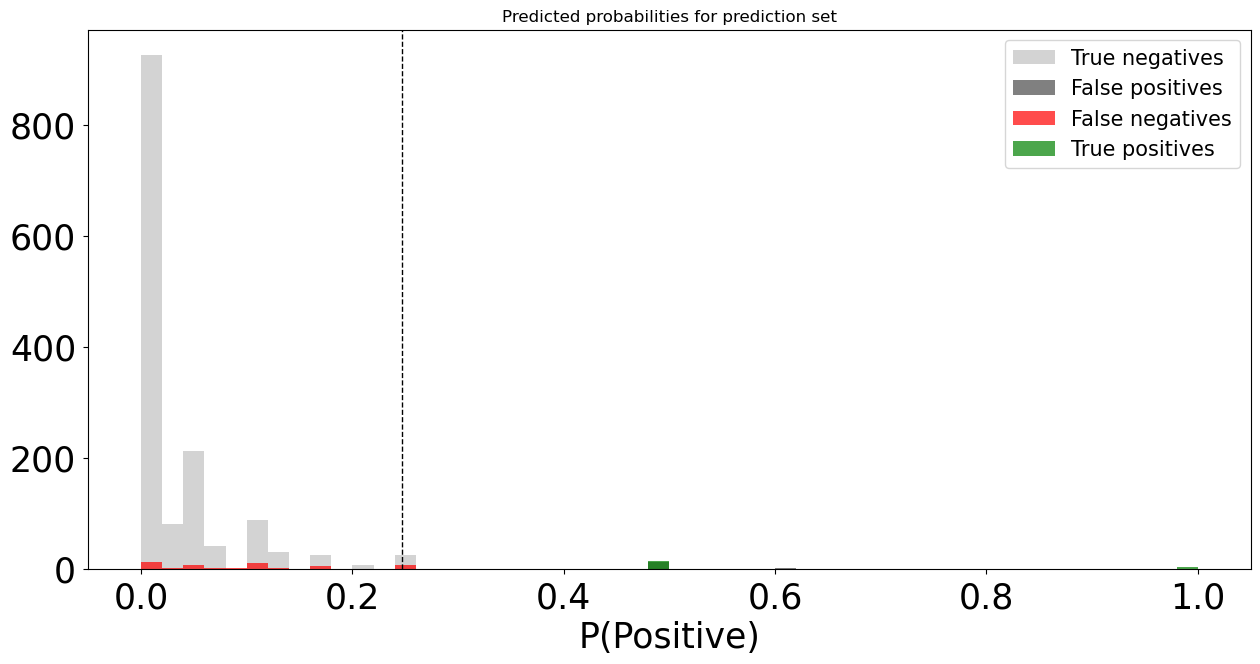

Test P(1) =  4.18%
Test P(1 | predicted 1) =  55.17%
Test P(1 | predicted 0) =  3.18%

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1445
           1       0.55      0.25      0.35        63

    accuracy                           0.96      1508
   macro avg       0.76      0.62      0.66      1508
weighted avg       0.95      0.96      0.95      1508



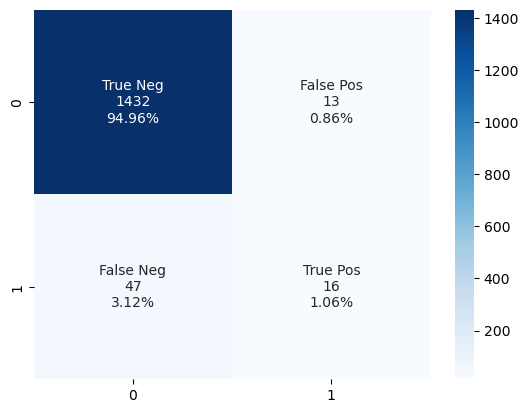

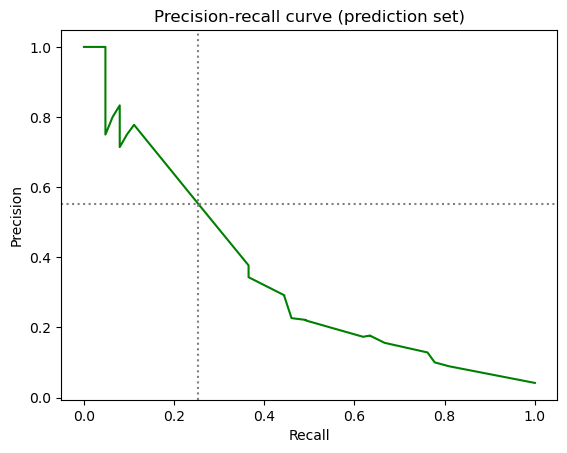

Cross validation results: 

fit_time: 75.92434854507447 (SD: 19.680701817475413)
score_time: 1.1261571884155273 (SD: 1.1561707974248203)
test_accuracy: 0.9580583940416239 (SD: 0.007905707942700905)
test_precision: 0.4330604403578109 (SD: 0.14382507613692908)
test_f1: 0.21178825541454696 (SD: 0.08756261470291685)
test_roc_auc: 0.7773958719337304 (SD: 0.03945578199332023)
test_neg_log_loss: -0.15238272201759218 (SD: 0.060074639090346243)
test_neg_brier_score: -0.032414682739414856 (SD: 0.0016111266086768538)

Predictions made: 1508
CPU times: user 1min 55s, sys: 59.2 s, total: 2min 55s
Wall time: 6min 50s


In [61]:
%%time

model_description = "Neural network"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from scikeras.wrappers import KerasClassifier

# Option 1: use cross validation to find the optimal hyperparameters
# import numpy as np
# import sklearn as skl
# classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0)
# #   test initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
# search_params = {'epochs': [10, 20, 40, 80, 100], 'batch_size': [16, 32], 'class_weight': [None], 'model__features': [surveyml.num_features], 'model__hidden_layers': [1, 2], 'model__initial_units': [surveyml.num_features, surveyml.num_features / 2], 'model__activation': ['relu', 'sigmoid'], 'model__l2_regularization': [True, False], 'model__l2_factor': skl.utils.fixes.loguniform(0.00001, 0.1), 'model__include_dropout': [True, False], 'model__dropout_rate': np.linspace(start=0.05, stop=0.5, num=10), 'model__output_bias': [None, np.log([surveyml.pos_train/surveyml.neg_train])]}
# params = surveyml.cv_for_best_hyperparameters(classifier=classifier_nn, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# Option 2: use results from an earlier CV search
# Best neg_brier_score: -0.031986077081684244
# Parameters: {'batch_size': 16, 'class_weight': None, 'epochs': 10, 'model__activation': 'relu', 'model__dropout_rate': 0.4, 'model__features': 674, 'model__hidden_layers': 1, 'model__include_dropout': False, 'model__initial_units': 674, 'model__l2_factor': 0.04212757223749326, 'model__l2_regularization': True, 'model__output_bias': array([-3.24872183])}
params = {'batch_size': 16, 'class_weight': None, 'epochs': 10, 'model__activation': 'relu', 'model__dropout_rate': 0.4, 'model__features': surveyml.num_features, 'model__hidden_layers': 2, 'model__include_dropout': False, 'model__initial_units': surveyml.num_features, 'model__l2_factor': 0.04212757223749326, 'model__l2_regularization': True, 'model__output_bias': [-3.24872183]}

# output summary of model
print(surveyml.build_nn_model(**{param[len("model__"):]:params[param] for param in params if param.startswith("model__")}).summary())
print()

# then fit the model using the optimal hyperparameters
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0, **params)
predictions = surveyml.run_prediction_model(classifier_nn, supports_cv=True)
print()
print(f"Predictions made: {len(predictions)}")

### Enumerator analysis

TBD

In [7]:
from ml4qc import SurveyML

# list star enumerators to benchmark against
star_enumerators = ["FR1331"]

# benchmark against our star enumerators
result_df = SurveyML.benchmark_by_category(features_df, pd.DataFrame(classes_df["Surveyor_ID"]), star_enumerators, random_state=random_state, n_jobs = -3, verbose=False)

# print results
print(f"Benchmarking against the following enumerators: {star_enumerators}")
print()
print(result_df)

Benchmarking against the following enumerators: ['FR1331']

                score
Surveyor_ID          
FR1331       0.190812
FR1310       0.114368
FR3044       0.100927
FR1345       0.099941
FR3042       0.099629
FR1296       0.098687
FR1861       0.098563
FR2303       0.094423
FR1338       0.093143
FR1333       0.089569
FR3035       0.089536
FR2167       0.088776
FR1286       0.087916
FR1346       0.087406
FR3037       0.084775
FR1376       0.083625
FR3040       0.083276
FR3034       0.083227
FR3041       0.081218
FR1907       0.080736
FR3043       0.079974
FR2230       0.078621
FR1320       0.078387
FR1299       0.077620
FR2254       0.072307
FR0380       0.071251
FR1390       0.071129
FR1417       0.069079
FR1598       0.063830
FR1414       0.063200
FR1551       0.061824
FR1852       0.061340
FR3036       0.059274
FR3038       0.050108
FR1855       0.048341
FR1857       0.044406
